# ARF: COMPTE RENDU
### de Toldi Melchior, de Bézenac Emmanuel

Pour ce compte rendu, nous allons nous évaluer les modèles vus en TME sur des problèmes de classification binaire. Nous utilisons les données proposés par le site kaggle.com, disponibles à partir du lieu suivant:

https://www.kaggle.com/c/titanic/data

### CHARGEMENT DES DONNÉES

In [4]:
import pandas as pd
path='../data/'
train_df=pd.read_csv(path+'final_train.csv',index_col=False)
test_df=pd.read_csv(path+'final_test.csv')
datax=train_df[['Pclass','Age','Parch','Fare','Embarked','Gender']].values
datay=train_df['Survived'].values

print(train_df.shape,test_df.shape)
train_df[:10]

((891, 8), (418, 7))


,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Gender
0,0,3,22,1,0,7.2500,2,1
1,1,1,38,1,0,71.2833,0,0
2,1,3,26,0,0,7.9250,2,0
3,1,1,35,1,0,53.1000,2,0
4,0,3,35,0,0,8.0500,2,1
5,0,3,28,0,0,8.4583,1,1
6,0,1,54,0,0,51.8625,2,1
7,0,3,2,3,1,21.0750,2,1
8,1,3,27,0,2,11.1333,2,0
9,1,2,14,1,0,30.0708,0,0


### CLASSE CLASSIFIER ET VALIDATION CROISÉE

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import namedtuple
import numpy as np

class Classifier(object):
    """ Classe generique d'un classifieur
        Dispose de 3 méthodes :
            fit pour apprendre
            predict pour predire
            score pour evaluer la precision
    """
    def fit(self,data,y):
        raise NotImplementedError("fit non  implemente")
    def predict(self,data):
        raise NotImplementedError("predict non implemente")
    def score(self,data,y):
        return (self.predict(data)==y).mean()

def v2m(x):
    return x.reshape((x.size,1)) if len(x.shape)==1 else x

def cross_validation(model,x,y,k):
    n=len(x)
    index_perm=np.random.permutation(range(n))
    scores=np.zeros((k))
    x_perm=x[[index_perm]]
    y_perm=y[[index_perm]]
    for index in range(k):        
        ik=int(float(index)*n/k)
        ikp1=int(float(index+1)*n/k)
        x_train=np.vstack((x_perm[:ik],x_perm[ikp1:]))
        y_train=np.concatenate((y_perm[:ik],y_perm[ikp1:]))
        x_test=x_perm[ik:ikp1]
        model.fit(x_train,y_train)        
        y_test=y_perm[ik:ikp1]
        scores[index]=model.score(x_test,y_test)
        #print('round '+str(index)+': '+str(scores[index])+'%.')
    return scores.mean()    

## ARBRES DE DÉCISION

### MODÈLE

In [3]:
import decisiontree as dt

import cPickle
fields={}
for index,f in enumerate(['Pclass','Age','Parch','Fare','Embarked','Gender']):
    fields[index]=f
dectree = dt.DecisionTree()
dectree.max_depth = 1
#dectree.fit(datax ,datay)

Couldn't import dot_parser, loading of dot files will not be possible.


### RÉSULTATS:

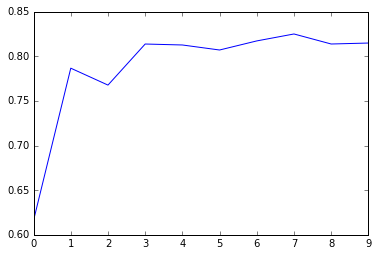

In [6]:
#print dectree.score(datax,datay)
max_depth=10
dec_score=np.zeros((max_depth))
for depth in range(max_depth):
    dectree.max_depth = depth
    dec_score[depth]=cross_validation(dectree,datax,datay,8)
plt.plot(range(max_depth),dec_score,label)
plt.show()
#dectree.to_pdf("tree.pdf",fields)

## NAIVE BAYES

### MODÈLE

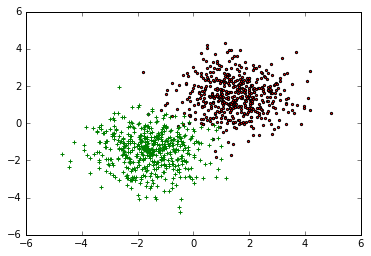

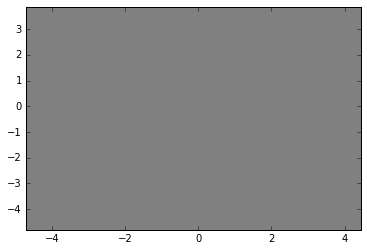

In [53]:
from arftools import *
import pandas as pd
import numpy as np

class Bayes(Classifier):
    def fit(self,x,y):
        self.nb_classes=len(np.unique(y))
        x_l=np.array([x[np.where(y==i)] for i in range(self.nb_classes)])
        mean=[[np.mean(x_l[j][:,i]) for i in range(x_l[j].shape[1])] for j in range(self.nb_classes)]
        std=[[np.std(x_l[j][:,i])+.1 for i in range(x_l[j].shape[1])] for j in range(self.nb_classes)]
        self.mean=np.array(mean)
        self.std=np.array(std)
    
    def predict(self,x):
        m,s=self.mean,self.std
        maxllog=np.zeros((x.shape[0]))
        for k in range(x.shape[0]):            
            maxllog[k]=np.argmax([np.sum([np.log(1/(np.sqrt(2*np.pi)*s[j][i])*np.exp((-0.5*(float(x[k][i]-m[j][i])/s[j][i])**2))) for i in range(x.shape[1])]) for j in range(m.shape[0])])
        return maxllog
    
    
    
df1=pd.read_csv('data/two_gaussians.csv',sep=';')
x1=df1[['x1','x2']].values
y1=df1['y'].values
plot_data(x1,y1)
plt.show()
bayes=Bayes()
bayes.fit(x1,y1)
plot_frontiere(x1,bayes.predict)

### RÉSULTATS:

In [8]:
bayes=Bayes()
cross_validation(bayes,datax,datay,8)

0.76432794401544402

## KNN

### MODÈLE

arftools.py:79: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if data!=None:


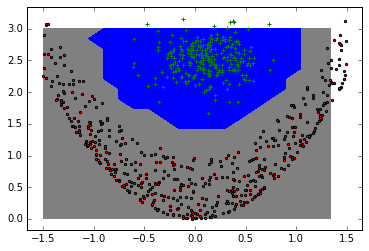

In [2]:
from arftools import *
import pandas as pd
import numpy as np
class KNN(Classifier):
    def __init__(self,k):
        self.k=k
        
    def fit(self,x,y):
        self.x=x
        self.y=y
        
    def predict(self,z):
        z_labels=np.zeros((len(z)))
        for index,j in enumerate(z):
            dist=np.array([np.linalg.norm(i-j) for i in self.x])
            arg_dist=np.argsort(dist)[:self.k]
            vote=self.y[arg_dist]
            vote = vote.astype(int)
            z_labels[index]=np.argmax(np.bincount(vote))
            
        return z_labels
    
df1=pd.read_csv('data/hyperbolic2.csv',sep=';')
x1=df1[['x1','x2']].values
y1=df1['y'].values
y1 = (y1+1)/2




knn=KNN(10)
knn.fit(x1,y1)
plot_frontiere(x1,knn.predict)
plot_data(x1,y1)

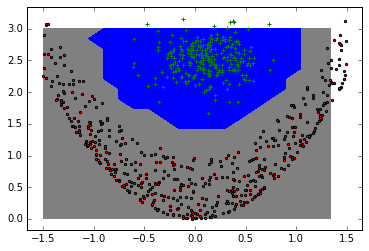

In [3]:
import arftools as arf
arf.plot_data_frontiere(data=x1,f=knn.predict,labels=y1)

### RÉSULTATS:

In [6]:
max_k=15
knn_score=np.zeros((max_k))
for k in range(1,max_k+1):
    knn=KNN(k=k)
    knn_score[k-1]=cross_validation(knn,datax,datay,8)
plt.plot(range(1,max_k+1),knn_score)
plt.show()

NameError: name 'datax' is not defined

## PERCEPTRON

### MODÈLE

In [18]:
def hinge(x,y,w):
    return np.maximum(0.,-(x.dot(w))*y)

def hinge_grad(x,y,w):
    return x*y

Fonction = namedtuple("Fonction",["f","grad","dim"]) #declaration de la structure
HINGE=Fonction(hinge,hinge_grad,6)

class Perceptron(Classifier):
    def __init__(self,loss=HINGE,max_iter=200,eps=0.00001):
        self.max_iter,self.eps=max_iter,eps
        self.w=None
        self.loss=loss
        
    def fit(self,datax,datay):
        datay=v2m(datay*2-1)
        self.w=np.random.random((len(datax[0]),1))-0.5
        self.max_iter=400
        for t in range(self.max_iter):
            hinge=self.loss[0](datax,datay,self.w)
            index_pos=np.where(hinge>0.)[0]
            grad=self.loss[1](datax,datay,self.w)
            self.w+=self.eps*np.array([np.sum(grad[index_pos],axis=0)]).T
            print 'hinge loss: '+str(np.sum(hinge))
            print 'fit score: '+str((1.-float(len(np.where(hinge>0.)[0]))/len(datax))*100)+'%.'
        
    def predict(self,datax):
         return (np.sign(datax.dot(self.w))+1)/2
df1=pd.read_csv('../data/two_gaussians.csv',sep=';')
x1=df1[['x1','x2']].values
y1=df1['y'].values
y1 = (y1+1)/2


#plot_data(x1,y1)
plt.show()

per=Perceptron()
per.fit(x1,y1)

#plot_frontiere(x1,per.predict)

hinge loss: 78.1649281838
fit score: 28.5%.
hinge loss: 53.5237653164
fit score: 39.6%.
hinge loss: 36.2478960651
fit score: 51.0%.
hinge loss: 24.9149214888
fit score: 60.4%.
hinge loss: 17.7468318213
fit score: 68.9%.
hinge loss: 13.3765819072
fit score: 74.1%.
hinge loss: 10.401483158
fit score: 77.8%.
hinge loss: 8.26432956961
fit score: 81.4%.
hinge loss: 6.75562063576
fit score: 84.1%.
hinge loss: 5.71728556775
fit score: 85.5%.
hinge loss: 4.86809354185
fit score: 86.5%.
hinge loss: 4.1847135074
fit score: 88.2%.
hinge loss: 3.6784307526
fit score: 89.3%.
hinge loss: 3.27404902775
fit score: 90.1%.
hinge loss: 2.94882182862
fit score: 91.3%.
hinge loss: 2.70424810396
fit score: 91.7%.
hinge loss: 2.48571635118
fit score: 92.5%.
hinge loss: 2.3173643374
fit score: 93.1%.
hinge loss: 2.17561028657
fit score: 93.3%.
hinge loss: 2.04410444914
fit score: 93.7%.
hinge loss: 1.92726862037
fit score: 94.0%.
hinge loss: 1.82224152726
fit score: 94.5%.
hinge loss: 1.7404334249
fit score: 

## Plots du perceptron

hinge loss: 57.1477273269
fit score: 76.7%.
hinge loss: 6.97088515537
fit score: 95.7%.
hinge loss: 4.35420656385
fit score: 96.9%.
hinge loss: 3.21746109354
fit score: 97.7%.
hinge loss: 2.5443822977
fit score: 98.3%.
hinge loss: 2.17834026901
fit score: 98.6%.
hinge loss: 1.97564555522
fit score: 98.6%.
hinge loss: 1.78433600142
fit score: 98.5%.
hinge loss: 1.62788334224
fit score: 98.6%.
hinge loss: 1.5264500119
fit score: 98.5%.
hinge loss: 1.43806527406
fit score: 98.5%.
hinge loss: 1.35754307348
fit score: 98.6%.
hinge loss: 1.27890239879
fit score: 98.6%.
hinge loss: 1.20026172409
fit score: 98.6%.
hinge loss: 1.12162104939
fit score: 98.6%.
hinge loss: 1.05354720726
fit score: 98.6%.
hinge loss: 1.02393222292
fit score: 98.7%.
hinge loss: 0.99751632898
fit score: 98.5%.
hinge loss: 0.976746717268
fit score: 98.6%.
hinge loss: 0.957903440067
fit score: 98.6%.
hinge loss: 0.939060162865
fit score: 98.6%.
hinge loss: 0.920216885663
fit score: 98.6%.
hinge loss: 0.901373608462
fit

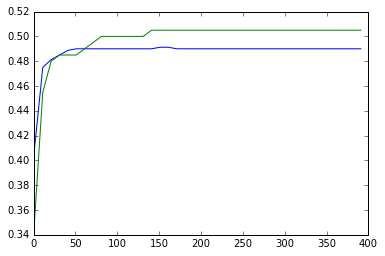

In [34]:
def hinge(x,y,w):
    return np.maximum(0.,-(x.dot(w))*y)

def hinge_grad(x,y,w):
    return x*y

Fonction = namedtuple("Fonction",["f","grad","dim"]) #declaration de la structure
HINGE=Fonction(hinge,hinge_grad,6)

class Perceptron(Classifier):
    def __init__(self,loss=HINGE,max_iter=100,eps=0.0001):
        
        self.max_iter,self.eps=max_iter,eps
        self.w=None
        self.loss=loss
        
    def fit(self,datax,datay):
        datay=v2m(datay*2-1)
        self.w=np.random.random((len(datax[0]),1))-0.5
        self.max_iter=400
        for t in range(self.max_iter):
            hinge=self.loss[0](datax,datay,self.w)
            index_pos=np.where(hinge>0.)[0]
            grad=self.loss[1](datax,datay,self.w)
            self.w+=self.eps*np.array([np.sum(grad[index_pos],axis=0)]).T
        #print 'hinge loss: '+str(np.sum(hinge))
        #print 'fit score: '+str((1.-float(len(np.where(hinge>0.)[0]))/len(datax))*100)+'%.'
        
    def predict(self,datax):
         return (np.sign(datax.dot(self.w))+1)/2
    
    def plot_fit(self,datax,datay):
        #Fitting
        datay=v2m(datay*2-1)
        self.w=np.random.random((len(datax[0]),1))-0.5
        self.max_iter=400
        #Pour le plotting
        ratio=0.8
        x_test=datax[int(ratio*len(datax)):]
        x_train=datax[:int(ratio*len(datax))]
        y_test=datay[int(ratio*len(datax)):]
        y_train=datay[:int(ratio*len(datax))]
        score_fit_plot=[]
        x_plot=[]
        score_predict_plot=[]
        for t in range(self.max_iter):
            if(t%10==1):
                x_plot.append(t)
                score_fit_plot.append(self.score(x_train,y_train))
                score_predict_plot.append(self.score(x_test,y_test))
                print 'hinge loss: '+str(np.sum(hinge))
                print 'fit score: '+str((1.-float(len(np.where(hinge>0.)[0]))/len(datax))*100)+'%.'
                
            hinge=self.loss[0](x_train,y_train,self.w)
            index_pos=np.where(hinge>0.)[0]
            grad=self.loss[1](x_train,y_train,self.w)
            self.w+=self.eps*np.array([np.sum(grad[index_pos],axis=0)]).T
        return x_plot,[score_fit_plot,score_predict_plot]
        
        #Plotting
    
    
df1=pd.read_csv('data/two_gaussians.csv',sep=';')

x1=df1[['x1','x2']].values
y1=df1['y'].values
y1 = (y1+1)/2


#plot_data(x1,y1)

plt.show()

per=Perceptron()
x_plot,y_plot=per.plot_fit(x1,y1)
#plt.xlabel='iteration'

plt.plot(x_plot,y_plot[0])
plt.plot(x_plot,y_plot[1])

#plot_frontiere(x1,per.predict)

### RÉSULTATS:

In [13]:
perc=Perceptron()
new_datax=np.zeros((datax.shape[0],datax.shape[1]+3))
new_datax[:,:6]=datax
print fields
new_datax[:,6]=np.log(new_datax[:,5]*new_datax[:,5]+1)
new_datax[:,7]=np.log(new_datax[:,3]*new_datax[:,3]+1)
new_datax[:,8]=np.log(new_datax[:,0]*new_datax[:,0]+1)


print new_datax.shape,datax.shape
perc.fit(datax,datay)
perc.fit(new_datax,datay)
#perc.predict(datax[:100])
print cross_validation(perc,datax,datay,8)
print("with new params:")
print cross_validation(perc,new_datax,datay,8)

{0: 'Pclass', 1: 'Age', 2: 'Parch', 3: 'Fare', 4: 'Embarked', 5: 'Gender'}
(891, 9) (891, 6)
0.556114251231
with new params:
0.537403736947
